In [1]:
# Upload THE TRAINING DATASET ZIP FILE
from google.colab import files
rc = list(files.upload().values())[0]

Saving baby_GT.bmp to baby_GT (1).bmp


In [2]:
# Upload THE TRAINING DATASET ZIP FILE
from google.colab import files
rc = list(files.upload().values())[0]

Saving wazirmodelscale4.h5 to wazirmodelscale4 (1).h5


In [1]:
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Activation, Input
import keras.backend as K
from keras import optimizers
import numpy as np
import h5py
from keras.layers import Input,Dense,Convolution2D,Activation,MaxPooling2D,Flatten,merge,concatenate
from keras.layers.merge import add
from keras.models import Model, load_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.layers.convolutional import Deconv2D as Conv2DTranspose
import scipy.misc
import scipy.ndimage
import cv2
import math
import glob
import matplotlib.pyplot as plt
import keras
from matplotlib import pyplot

/home/wazir/.virtualenvs/wazir/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def Res_block():
    _input=Input(shape=(None,None,64))
    conv=Conv2D(64,(3,3),strides=(1,1),padding='same',activation='relu')(_input)
    conv=Conv2D(64,(3,3),strides=(1,1),padding='same',activation='linear',name='LINEAR')(conv)
    out=add(inputs=[_input,conv])
    out=Activation('relu')(out)
    model=Model(inputs=_input,outputs=out)
    return model

In [3]:
_input=Input(shape=(None,None,1),name='input')
Feature=Conv2D(64,(3,3),strides=(1,1),padding='same',activation='relu')(_input)
Feature_out=Res_block()(Feature)
Upsampling1= Conv2D(4,(1,1),strides=(1,1),padding='same',activation='relu')(Feature_out)
Upsampling2=Conv2DTranspose(4,(14,14),strides=(1,1),padding='same',activation='relu',name='RELU4')(Upsampling1)
Upsampling3=Conv2D(64,(1,1),strides=(1,1),padding='same',activation='relu',name='RELU5')(Upsampling2)
Reslayer1=Res_block()(Upsampling3)
Reslayer2=Res_block()(Reslayer1)
Multi_scale1=Conv2D(16,(1,1),strides=(1,1),padding='same',activation='relu')(Reslayer2)
Multi_scale2a=Conv2D(16,(1,1),strides=(1,1),padding='same',activation='relu')(Multi_scale1)
Multi_scale2b=Conv2D(16,(1,3),strides=(1,1),padding='same',activation='relu')(Multi_scale1)
Multi_scale2b=Conv2D(16,(3,1),strides=(1,1),padding='same',activation='relu')(Multi_scale2b)
Multi_scale2c=Conv2D(16,(1,3),strides=(1,1),padding='same',activation='relu')(Multi_scale1)
Multi_scale2c=Conv2D(16,(3,1),strides=(1,1),padding='same',activation='relu')(Multi_scale2c)
Multi_scale2d=Conv2D(16,(1,7),strides=(1,1),padding='same',activation='relu')(Multi_scale1)
Multi_scale2d=Conv2D(16,(7,1),strides=(1,1),padding='same',activation='relu')(Multi_scale2d)
Multi_scale2e=Conv2D(16,(1,7),strides=(1,1),padding='same',activation='relu')(Multi_scale2d)
Multi_scale2f=Conv2D(16,(7,1),strides=(1,1),padding='same',activation='relu')(Multi_scale2e)
Multi_scale2g=Conv2D(16,(1,9),strides=(1,1),padding='same',activation='relu')(Multi_scale2f)
Multi_scale2=concatenate(inputs=[Multi_scale2a, Multi_scale2b, Multi_scale2c, Multi_scale2d,Multi_scale2e, Multi_scale2f, Multi_scale2g])
out=Conv2D(1, (1, 1), strides=(1, 1), padding='same', activation='relu')(Multi_scale2)
model=Model(input=_input, output=out)
opt = optimizers.Adam(lr=0.0003)
model.compile(optimizer=opt,loss='mean_squared_error',metrics=['accuracy'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, None, 1 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 6 640         input[0][0]                      
__________________________________________________________________________________________________
model_1 (Model)                 (None, None, None, 6 73856       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, None, None, 4 260         model_1[1][0]                    
_____________________________________

/home/wazir/.virtualenvs/wazir/lib/python3.5/site-packages/ipykernel_launcher.py:22: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("co..., inputs=Tensor("in...)`


In [4]:
#LOAD THE TRAINED MODEL
wazirmodel = load_model('wazirmodelscale4.h5')

Instructions for updating:
Use tf.cast instead.


In [5]:
def modcrop(image, scale=4): # SCALE FACTOR = 4
    if len(image.shape) == 3:
        h, w, _ = image.shape
        h = h - np.mod(h, scale)
        w = w - np.mod(w, scale)
        image = image[0:h, 0:w, :]
    else:
            h, w = image.shape
            h = h - np.mod(h, scale)
            w = w - np.mod(w, scale)
            image = image[0:h, 0:w]
            return image

In [6]:
def create_LR(image,scale):
    label_ = modcrop(image, scale)
    # Must be normalized
    label_ = label_ / 255.
    input_ = scipy.ndimage.interpolation.zoom(label_, (1./scale), prefilter=False)
    input_ = scipy.ndimage.interpolation.zoom(input_, (scale/1.), prefilter=False)
    return input_

In [20]:
img_o = scipy.misc.imread('Set5/vtrg2.png',flatten=True,mode='YCbCr').astype(np.float)
img = create_LR(img_o,4)#######################################################
img_size = 64
stride = 32
h,w = img.shape
piece_wise = []
for x in range(0, h-img_size+1, stride):
  for y in range (0, w-img_size+1, stride):
    sub_input = img[x:x+img_size, y:y+img_size].reshape(img_size,img_size,1)
    piece_wise.append(sub_input)
input_ = np.asarray(piece_wise)
hat = wazirmodel.predict(input_)
img_re = np.zeros(img.shape)
i = 0
for x in range(0, h-img_size+1, stride):
  for y in range (0, w-img_size+1, stride):
    img_re[x:x+img_size, y:y+img_size] = hat[i].reshape(img_size,img_size)
    i += 1
cv2.imwrite('restored1.bmp', img_re)
cv2.imwrite('HR1.bmp', img_o)
img_save = (img*255).astype(np.uint8)
cv2.imwrite('lowresolution.bmp',img_save)

/home/wazir/.virtualenvs/wazir/lib/python3.5/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


True

In [21]:
#CALCULATE PSNR
original = cv2.imread("HR1.bmp")
lowresolution = cv2.imread("lowresolution.bmp",1)
contrast = cv2.imread("restored1.bmp",1)
def psnr(img1, img2):
  mse = np.mean((img1-img2)**2)
  if mse ==0:
        return 100
  PIXEL_MAX = 255.0
  return 20* math.log10(PIXEL_MAX / math.sqrt(mse))
d = psnr(original,contrast)
print(d)

30.757687873417495


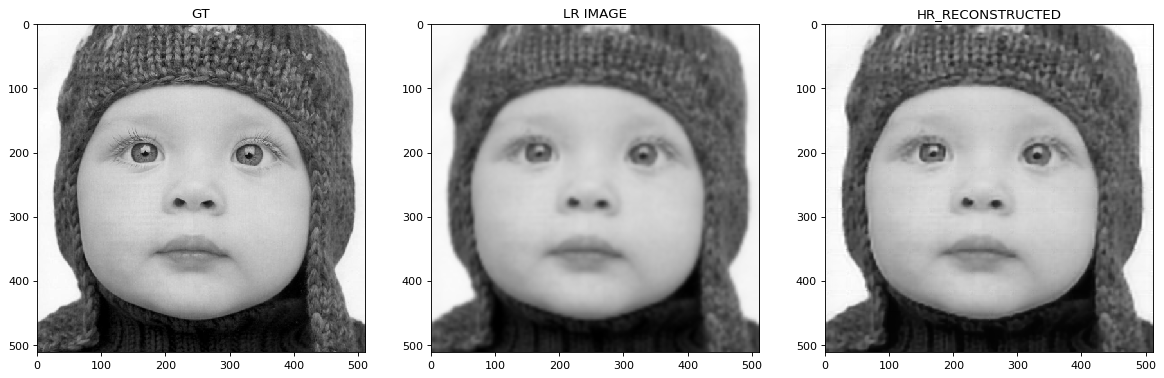

In [10]:
fig = plt.figure(figsize = (18,18), dpi = 80)
ax = plt.subplot("131")
ax.imshow(original)
ax.set_title("GT")
plt.grid(0)

ax = plt.subplot("132")
ax.imshow(lowresolution)
ax.set_title("LR IMAGE")
plt.grid(0)



ax = plt.subplot("133")
ax.imshow(contrast)
ax.set_title("HR_RECONSTRUCTED")
plt.grid(0)
plt.show()
